## Testing wide deep model example 

Following [original paper](https://arxiv.org/pdf/1606.07792.pdf) and primarily this [workshop](https://noelkonagai.github.io/Workshops/tensorflow_pt2_widedeep/). Additionally these resources: 
- [how to build wide deep model w. keras and tf2] (https://towardsdatascience.com/how-to-build-a-wide-and-deep-model-using-keras-in-tensorflow-2-0-2f7a236b5a4b) and its [code](https://github.com/GoogleCloudPlatform/data-science-on-gcp/blob/master/09_cloudml/flights_model_tf2.ipynb)
-[feature crossing tutorial](https://developers.google.com/machine-learning/crash-course/feature-crosses/crossing-one-hot-vectors)

Other implementations to look at:  
[1](https://github.com/Mohit67/Movie_recommendar/blob/master/wide_n_deep_tutorial.py),[2](https://github.com/wangby511/Recommendation_System), [3](https://github.com/AmoghM/Yelp-Restaurants-RecSys), [4](https://github.com/rajaharsha/Wide-Deep-Neural-Networks), [5](https://github.com/wang-henry4/wide-and-deep-recommender-model),[6](https://devblogs.nvidia.com/accelerating-wide-deep-recommender-inference-on-gpus/), [7](https://humboldt-wi.github.io/blog/research/information_systems_1718/08recommendation/),[8](https://www.youtube.com/watch?v=m_AZrITxs5M&t=0s)

In [0]:
from google.colab import drive
drive.mount('/content/drive/')
prefix = './drive/My Drive/ND_CSE/Year_1/Research:Care-Net/JBDF_CareNet/Care-Net Backend/code_and_data'
!echo "Project dir contents:" && ls "$prefix/"
!echo -e "\nColab Notebook home dir:" && ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
Project dir contents:
211_IN_Data_Parsing.ipynb    models
binder			     Node_Text_Embedding_sBERT.ipynb
data			     README.md
demos			     semantic_embeddings_cluster_plot.ipynb
embeddings		     service_embeddings_UMAP.ipynb
embed_serv_sim_search.ipynb  USE_embeddings.ipynb
figures			     USE_embed_serv_sim_search.ipynb
Graph_Data_Extraction.ipynb

Colab Notebook home dir:
drive  sample_data


In [0]:
!pip install -U ipykernel tensorflow-text==2.2.0rc2 plot-keras-history

     |████████████████████████████████| 122kB 2.7MB/s 
     |████████████████████████████████| 3.0MB 7.2MB/s 
  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.23-cp36-none-any.whl size=6405 sha256=6583f8bb5ba7ca64b4cf11243bd6d65523653a9e974a640555efa84d52adc761
  Stored in directory: /root/.cache/pip/wheels/c0/78/33/da5ed769fab5587fcdae95271e8d19106e3b92b3ae2d46382d
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.9-cp36-none-any.whl size=6476 sha256=4b2675f7bc392496ff9b2a9ecb0da3dc3f7d68724ac079e96fde4a06f9b123ce
  Stored in directory: /root/.cache/pip/wheels/9d/e9/ec/ca775287a4d0f9e87a56220bf82ca01d9cff045026271fad24
Successfully built plot-keras-history sanitize-ml-labels
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.2.0 which is incompatible.
  Found existing installation: ipykernel 4.10.1
    Uninstalling ipykernel-4.10.1:
      Successfully uninstalled ipykernel-4.10.1


In [0]:
# Copyright 2017 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Download and clean the Census Income Dataset."""

import argparse
import os
import shutil

try:
    %tensorflow_version 2.x
except Exception as e:
    print(e)
import tensorflow as tf

import pandas as pd
import json
import csv
import pickle
import numpy as np
import os
from tqdm import tqdm
import tensorflow_hub as hub
import random
import multiprocessing
import ast
from sklearn.model_selection import train_test_split
# import tensorflow_text

#### Default Args and names

In [0]:
# tf.enable_eager_execution()
# PREFIX = '/afs/crc.nd.edu/user/a/aveganog/ND_Care_Net'
PREFIX = './drive/My Drive/ND_CSE/Year_1/Research:Care-Net/JBDF_CareNet/Care-Net Backend/code_and_data'
TRAINING_FILE = 'care-net.train'
EVAL_FILE = 'care-net.test'

NODE_TYPE = 'services'

# needed for file name below
MODEL = 'USE'
# MODEL_URL = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3'
# MODEL_URL = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3'
MODEL_URL = 'https://tfhub.dev/google/universal-sentence-encoder/4'
MODEL_TYPE = MODEL_URL.split('/')[-2]
MODEL_VER = MODEL_URL.split('/')[-1]

!mkdir -p "$prefix/embeddings/$MODEL/"
print("Using embeddings from Model {}_{}_v{}".format(MODEL, MODEL_TYPE, MODEL_VER))

DATA_DIR = os.path.join(PREFIX, 'data', 'wide_deep_dataset_chunks')

# help = 'Base directory for the model.')
MODEL_TYP = 'deep_only'
# MODEL_TYP = 'wide-USE'
MODEL_DIR = os.path.join(PREFIX, 'models', 'wide_and_deep_{}'.format(MODEL), MODEL_TYP)

# help = 'Number of training epochs.')
TRAIN_EPOCHS = 15

# help = 'The number of training epochs to run between evaluations.')
EPOCHS_PER_EVAL =2 

# help = 'Number of examples per batch.')
BATCH_SIZE = 512
QBAT_SIZE = 512

# parser.add_argument(
#     '--train_data', type=str, default='/tmp/census_data/adult.data',
#     help='Path to the training data.')

# parser.add_argument(
#     '--test_data', type=str, default='/tmp/census_data/adult.test',
#     help='Path to the test data.')

TRAIN_PCNT = 0.7 
TEST_PCNT = 1 - TRAIN_PCNT

CSV_COLUMNS = [
            'Distance',
            'Embedding_Similarity',
            'Month',
            'Selected_Service_Embedding',
            'Candidate_Service_Embedding', 
            # 'Previously_Recommended',
            'Query',
            'Label'
]

CSV_COLUMN_DEFAULTS = [[0.0], [0.0], [0.0], [0], [''], [0], [0], [0]]

Using embeddings from Model USE_universal-sentence-encoder_v4


In [0]:
 # download auxillary data
# tf.enable_eager_execution()
 # json nodes of 211 IN services
with open(PREFIX + '/data/services_nodes.json') as sn:
    serv_nodes = json.loads(sn.read())

# our heterogeneous information network. 
# we're only using the services data
with open(PREFIX + '/data/HIN_nodes.json') as taxo:
    hin_nodes = json.loads(taxo.read())

# map service_ids to node numbers in our graph
with open(PREFIX + '/data/service_id_to_node_num.json') as sn:
    serv_trans = json.loads(sn.read())

# map 211 taxonomy codes to their node number in our graph
with open(PREFIX + '/data/code_to_node_num.json') as ct:
    code_trans = json.loads(ct.read())

# map 211 taxonomy codes to their node number in our graph
with open(PREFIX + '/data/tagged_texts.json') as ct:
    tagged_texts = json.loads(ct.read())

# load list of queries/keywords from taxonomy data
queries_path = os.path.join(PREFIX, 'data', 'HIN_references.csv')
with open(queries_path) as qf:
  queries = qf.read()
  queries = queries.split(',')
  # cleanup some bad data. TODO: Fix in notebook that generates the data
  queries = [''] + [q for q in queries if q != '']

# fetch the embeddings of the social services for our dataset later
# tagged_embeds = {}
# embed_path = os.path.join(PREFIX, 'embeddings', MODEL, "{}_{}_v{}.pkl".format(
#     NODE_TYPE, MODEL_TYPE, MODEL_VER
#     ))
    
# if os.path.exists(embed_path):
#   print("Loading embeddings from {}".format(embed_path))
#   with open(embed_path, 'rb') as f:
#         tagged_embeds = pickle.load(f)

# for k in tagged_embeds:
#     # flatten our embeddings mapping
#     tagged_embeds[k] = tagged_embeds[k]['embed']

### Now we can build, run, and eval the test wide deep model

#### Build input feature columns

In [0]:
def build_model_columns():
    """Builds a set of wide and deep feature columns."""
    # Continuous columns
    distance = tf.feature_column.numeric_column('Distance', shape=(1,), dtype=tf.float32)
    similarity = tf.feature_column.numeric_column('Embedding_Similarity', shape=(1,))
    # month of referral
    month = tf.feature_column.categorical_column_with_hash_bucket('Month', hash_bucket_size=13, dtype=tf.string)
    month = tf.feature_column.indicator_column(month)

    # selected_emb = hub.text_embedding_column('Selected_Service_Embedding', MODEL_URL)
    # candidate_emb = hub.text_embedding_column('Candidate_Service_Embedding', MODEL_URL)
    # query_emb = hub.text_embedding_column('Query', MODEL_URL) 

    #   prev_recs = tf.feature_column.numeric_column(key='Previously_Recommended',shape=(16547,))
    voc_list = [str(serv_nodes[nid]['serv_id']) for nid in serv_nodes]
    prev_recs = tf.feature_column.categorical_column_with_vocabulary_list(key='Previously_Recommended', vocabulary_list=voc_list, dtype=tf.string)
    prev_recs = tf.feature_column.embedding_column(prev_recs,32)
    serv_id = tf.feature_column.categorical_column_with_hash_bucket('Selected_Service_ID', hash_bucket_size=50000)
    serv_id = tf.feature_column.embedding_column(serv_id, 16)
    bucket_sim = tf.feature_column.bucketized_column(similarity, [0.2,0.4,0.6,0.8])
    cross = tf.feature_column.crossed_column([bucket_sim, 'Selected_Service_ID'], hash_bucket_size=20000)
    # try this later to combine embeddings into one feature:
    # https://www.tensorflow.org/api_docs/python/tf/feature_column/shared_embeddings
    
    # Wide columns and deep columns.
    base_columns = [
        distance, similarity, month#, prev_recs
    ]

    crossed_columns = [
        tf.feature_column.indicator_column(cross)
    ]

    wide_columns = base_columns + [serv_id] + crossed_columns #+ [bucket_sim]

    deep_columns = [
        # selected_emb, candidate_emb, query_emb
        None
    ]

    return wide_columns, deep_columns

In [0]:
data_files = os.listdir(DATA_DIR)
data_files = [os.path.join(DATA_DIR, f) for f in data_files]

In [0]:
nid_idxs = {}
for i, nid in enumerate(hin_nodes):
    nid_idxs[nid] = i

# save indexes of services to use in our dataset for embedding lookup
sid_idxs = {}
for i, sid in enumerate(serv_trans):
    sid_idxs[sid] = i

In [0]:
max_rec_len = 0

def preproc_query(emb_key):
    # idx = None
    # if str(emb_key) == 'nan':
    #     emb_key = ''
    if emb_key in q_idxs:
        idx = q_idxs[str(emb_key)]
    else:
        if str(emb_key) not in tagged_embeds:
            tagged_embeds[str(emb_key)] = extract_embed([str(emb_key)])
        q_idxs[str(emb_key)] = len(tagged_embeds.keys()) - 1
        idx = q_idxs[str(emb_key)]
    return idx

def preproc_serv(node_num):
    text = ''
    if str(node_num) == 'nan':
        node_num = ''
    if str(node_num) in sid_idxs:
        nid = serv_trans[str(node_num)]
        text = ' '.join(tagged_texts[nid])
    elif str(node_num) in nid_idxs:
        nid = str(node_num)
        text = ' '.join(tagged_texts[nid])
    elif serv_trans[str(node_num)] in sid_idxs:
        idx = sid_idxs[str(node_num)]
        text = '!'
    return text

def preproc_rec(rec):
    serv_ids = [sid for sid in list(serv_trans.keys())]
    rec = rec.replace('\'', '"')
    # print(type(rec))
    recs = json.loads(rec)
    global max_rec_len
    len_recs = len(recs)
    if len_recs > max_rec_len:
        max_rec_len = len_recs
        
    return recs

def pad_recs(recs):
    global max_rec_len
    for i in range((max_rec_len - len(recs))):
        recs.append('')
    return recs

def preproc_lbl(lbl):
    print(int(lbl))
    return int(lbl)

In [0]:
CSV_COLUMNS_OG = [
            'Distance',
            'Embedding_Similarity',
            'Month',
            'Selected_Service_Embedding',
            'Candidate_Service_Embedding', 
            'Previously_Recommended',
            'Query',
            'Label'
]

DEEP_COLUMNS = [
            'Selected_Service_Embedding',
            'Candidate_Service_Embedding', 
            'Query'
]

WIDE_COLUMNS = [
            'Distance',
            'Embedding_Similarity',
            'Month'
]

CSV_COLUMNS = [
            'Distance',
            'Embedding_Similarity',
            'Month',
            'Selected_Service_Embedding',
            'Candidate_Service_Embedding', 
            # 'Previously_Recommended',
            'Query',
            'Label'
]

from tqdm import tqdm
from sklearn import preprocessing

LABEL_NAME = CSV_COLUMNS[-1]
serv_ids = None
def load_df(files, has_checkpoints=False):

    data_df = []
    tot = len(files)
    for i, f in enumerate(files):
        fname = f.split('/')[-1]
        # skip hidden files
        if fname[0] == '.':
            continue
        if has_checkpoints:
            data_df.append(pd.read_parquet(f))
        else:
            data_df.append(pd.read_csv(f, nrows=5000))
        print("loaded file {} {} of {}".format(fname, i+1, tot))
    data_df = pd.concat(data_df)

    if not has_checkpoints:
        
        # ignore indexing column
        data_df.columns = CSV_COLUMNS_OG
        # data_df = data_df.replace(np.nan, '', regex=True)
        data_df[CSV_COLUMNS[0]].fillna(-1.0, inplace=True)
        data_df[CSV_COLUMNS[1]].fillna(0.0, inplace=True)
        data_df[CSV_COLUMNS[2]].fillna(0.0, inplace=True)
        data_df[CSV_COLUMNS[3]].fillna('', inplace=True)
        data_df[CSV_COLUMNS[4]].fillna('', inplace=True)
        data_df[CSV_COLUMNS[5]].fillna('', inplace=True)
        data_df[CSV_COLUMNS[6]].fillna('', inplace=True)
        # train_data[CSV_COLUMNS[0]].fillna(0.0, inplace=True)
        
        # data_df.replace({CSV_COLUMNS[7]:{np.nan: 0}})
        # fetch pre-computed embeddings of our text features
        print("Adding Service ID column")
        serv_ids = data_df[CSV_COLUMNS[3]].apply(lambda x: hin_nodes[str(x)]['serv_id'])
        
        # data_df = data_df.dropna()
        tqdm.pandas()
        
        z_score_scaler = preprocessing.StandardScaler()
        data_df[CSV_COLUMNS[0]] = z_score_scaler.fit_transform(data_df[CSV_COLUMNS[0]].values.reshape(-1,1))
        data_df[CSV_COLUMNS[3]] = data_df[CSV_COLUMNS[3]].progress_apply(lambda f: preproc_serv(f))
        data_df[CSV_COLUMNS[4]] = data_df[CSV_COLUMNS[4]].progress_apply(lambda f: preproc_serv(f))
        # data_df[CSV_COLUMNS[5]] = list(data_df[CSV_COLUMNS[5]].apply(lambda f: preproc_rec(f)))
        # data_df[CSV_COLUMNS[5]] = list(data_df[CSV_COLUMNS[5]].apply(lambda f: pad_recs(f)))
        # data_df[CSV_COLUMNS[5]] = data_df[CSV_COLUMNS[5]].progress_apply(lambda f: preproc_query(f))
        
        # data_df = data_df[CSV_COLUMNS]
        labels = data_df.pop('Label')
        CSV_COLUMNS[-1] = 'Selected_Service_ID'
        data_df[CSV_COLUMNS[-1]] = np.array(serv_ids.values).astype(np.int32)
        data_df = data_df[DEEP_COLUMNS]
        # data_df = data_df[WIDE_COLUMNS + ['Selected_Service_ID']]
        # data_df = data_df[WIDE_COLUMNS]
    
    return train_test_split(data_df.values, labels.values, train_size=0.7, random_state=19, shuffle=True)

In [0]:
import glob

has_checkpoints = False
# ds_files = glob.glob(os.path.join(PREFIX, 'data', 'dataset_chunks*.h5'))
# # check files exists and are correct format
# if ds_files and all(list(map(lambda x: x.split('.')[-1] == 'h5', ds_files))):
#     data_files = ds_files
#     has_checkpoints = True
#     print("Using pre-existing dataset checkpoints:\n{}".format('\n'.join))
X_train, X_val, y_train, y_val = load_df(data_files, has_checkpoints)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=(0.6/0.8), random_state=19, shuffle=True)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.7/0.9, random_state=19, shuffle=True)
print("Using train data with shape: {}".format(X_train.shape))
print("Using test data with shape: {}".format(X_test.shape))

loaded file wide_deep_dataset_chkpnt_0-63.csv 2 of 97
loaded file wide_deep_dataset_chkpnt_64-127.csv 3 of 97
loaded file wide_deep_dataset_chkpnt_128-191.csv 4 of 97
loaded file wide_deep_dataset_chkpnt_429-492.csv 5 of 97
loaded file wide_deep_dataset_chkpnt_365-428.csv 6 of 97
loaded file wide_deep_dataset_chkpnt_192-300.csv 7 of 97
loaded file wide_deep_dataset_chkpnt_557-620.csv 8 of 97
loaded file wide_deep_dataset_chkpnt_493-556.csv 9 of 97
loaded file wide_deep_dataset_chkpnt_685-748.csv 10 of 97
loaded file wide_deep_dataset_chkpnt_621-684.csv 11 of 97
loaded file wide_deep_dataset_chkpnt_301-364.csv 12 of 97
loaded file wide_deep_dataset_chkpnt_749-911.csv 13 of 97
loaded file wide_deep_dataset_chkpnt_912-975.csv 14 of 97
loaded file wide_deep_dataset_chkpnt_1040-1103.csv 15 of 97
loaded file wide_deep_dataset_chkpnt_976-1039.csv 16 of 97
loaded file wide_deep_dataset_chkpnt_1104-1167.csv 17 of 97
loaded file wide_deep_dataset_chkpnt_1232-1295.csv 18 of 97
loaded file wide_de

100%|██████████| 480000/480000 [00:01<00:00, 336373.99it/s]


Using train data with shape: (251999, 3)
Using test data with shape: (84001, 3)


In [0]:
X_tr = pd.DataFrame(X_train)
X_tr.columns = DEEP_COLUMNS
X_vl = pd.DataFrame(X_val)
X_vl.columns = DEEP_COLUMNS
X_te = pd.DataFrame(X_test)
X_te.columns = DEEP_COLUMNS
print("Using train dataset with shape: {}".format(X_train.shape))
print("Using validation dataset with shape: {}".format(X_val.shape))
print("Using test dataset with shape: {}".format(X_test.shape))
X_tr.head()

Using train dataset with shape: (251999, 3)
Using validation dataset with shape: (144000, 3)
Using test dataset with shape: (84001, 3)


,Selected_Service_Embedding,Candidate_Service_Embedding,Query
0,emergency aid program provides assistance util...,free white cane program offer free white cane ...,Gas Bill Help
1,legal line provides free legal advice caller e...,low interest loan provides loan homeowner low ...,Comprehensive Legal Aid
2,clothing emporium offer free clothing individu...,trustee assistance may able assist township re...,General Apparel
3,food pantry provides perishable nonperishable ...,sanitation provides sewer service wastewater t...,Infant Formula Donation Programs
4,taxpayer legal assistance bloomington litc ass...,girl scout promotes development leadership gir...,Comprehensive Legal Aid


In [0]:
CSV_COLUMNS = [
            'Distance',
            'Embedding_Similarity',
            'Month',
            'Selected_Service_Embedding',
            'Candidate_Service_Embedding', 
            # 'Previously_Recommended',
            'Query',
            'Selected_Service_ID'
]

# following: https://towardsdatascience.com/how-to-build-a-wide-and-deep-model-using-keras-in-tensorflow-2-0-2f7a236b5a4b

# initialize inputs for model with appropriate keras layers
wide_in = {}
deep_in = {}
for i in range(len(CSV_COLUMNS)):
    if i in (0,1):
        print("Wide Input: Added {} input layer as float32".format(CSV_COLUMNS[i]))
        wide_in[CSV_COLUMNS[i]] = tf.keras.layers.Input(name=CSV_COLUMNS[i], shape=(1,), dtype='float32')
        # inputs[CSV_COLUMNS[i]] = tf.keras.layers.Input(name=CSV_COLUMNS[i], shape=(1,), dtype='float32')
    elif i in (3,4,5):
        print("Deep Input: Added {} input layer as string".format(CSV_COLUMNS[i]))
        deep_in[CSV_COLUMNS[i]] = tf.keras.layers.Input(name=CSV_COLUMNS[i], shape=(), dtype='string')
        # inputs[CSV_COLUMNS[i]] = tf.keras.layers.Input(name=CSV_COLUMNS[i], shape=(512,), dtype='float32')
    # elif i == 5:
    #     print("Added {} input layer as list of strings".format(CSV_COLUMNS[i]))
    #     wide_in[CSV_COLUMNS[i]] = tf.keras.layers.Input(name=CSV_COLUMNS[i], shape=(16547,), dtype='string')
        # inputs[CSV_COLUMNS[i]] = tf.keras.layers.Input(name=CSV_COLUMNS[i], shape=(16547,), dtype='int32')
    elif i in (2,6):
        print("Wide Input: Added {} input layer as string".format(CSV_COLUMNS[i]))
        wide_in[CSV_COLUMNS[i]] = tf.keras.layers.Input(name=CSV_COLUMNS[i], shape=(1,), dtype='string')
    # else:
    #     print("Added {} input layer as string".format(CSV_COLUMNS[i]))
    #     wide_in[CSV_COLUMNS[i]] = tf.keras.layers.Input(name=CSV_COLUMNS[i], shape=(1,), dtype='string')

Wide Input: Added Distance input layer as float32
Wide Input: Added Embedding_Similarity input layer as float32
Wide Input: Added Month input layer as string
Deep Input: Added Selected_Service_Embedding input layer as string
Deep Input: Added Candidate_Service_Embedding input layer as string
Deep Input: Added Query input layer as string
Wide Input: Added Selected_Service_ID input layer as string


In [0]:
print(wide_in)
print(deep_in)

{'Distance': <tf.Tensor 'Distance:0' shape=(None, 1) dtype=float32>, 'Embedding_Similarity': <tf.Tensor 'Embedding_Similarity:0' shape=(None, 1) dtype=float32>, 'Month': <tf.Tensor 'Month:0' shape=(None, 1) dtype=string>, 'Selected_Service_ID': <tf.Tensor 'Selected_Service_ID:0' shape=(None, 1) dtype=string>}
{'Selected_Service_Embedding': <tf.Tensor 'Selected_Service_Embedding:0' shape=(None,) dtype=string>, 'Candidate_Service_Embedding': <tf.Tensor 'Candidate_Service_Embedding:0' shape=(None,) dtype=string>, 'Query': <tf.Tensor 'Query:0' shape=(None,) dtype=string>}


In [0]:
# import tensorflow_text

# Load the TF-Hub module
print("Loading the TF-Hub {} module...".format(MODEL))
print("TF-Hub module is loaded.")


embed_fn = hub.load(MODEL_URL)

def extract_embed(text):

    # import tensorflow_hub as hub
    # text = tf.reshape(text, [-1])
    # return embed_fn.signatures["default"](tf.squeeze(tf.cast(text, tf.string)))['default']
    return embed_fn(text)#['default']

Loading the TF-Hub USE module...
TF-Hub module is loaded.


In [0]:
# import random
MODEL_DIR = os.path.join(PREFIX, 'models', MODEL_TYP, "init_baseline_deep-only")#.format(BATCH_SIZE)) #+ str(random.randint(1,1001))
print("Using model dir {}".format(MODEL_DIR))

config = tf.estimator.RunConfig(model_dir=MODEL_DIR, tf_random_seed=42, save_summary_steps=100,
    save_checkpoints_steps=250, session_config=None, keep_checkpoint_max=50, 
    keep_checkpoint_every_n_hours=1,session_creation_timeout_secs=7200)

def rec_line_gen(R):
    for r in range(len(R)):
        print(R.shape)
        print(r)
        yield np.asarray(R[r])

def deep_input_generator(X,y):
    while True:
        X = np.array(X)
        for i in range(len(X)):
            x1,x2,x3 = X[:,i]
            yield str(x1),str(x2),str(x3),y[i]

def deep_input_fn(X, y, shuffle=True):
    
    def parse_line(f1,f2,f3,f4):
        cols = [f1,f2,f3,f4]
        lbl = cols.pop(-1)
        labels = {'Pred': lbl}

        # feats = dict(zip(CSV_COLUMNS, cols))
        feats = dict(zip(DEEP_COLUMNS, cols))
        # feats = dict(zip(WIDE_COLUMNS + ['Selected_Service_ID'], cols))
        # feats = dict(zip(WIDE_COLUMNS, cols))
        return feats,labels

    sel = X['Selected_Service_Embedding'].values
    cand = X['Candidate_Service_Embedding'].values
    query = X['Query'].values

    ds4 = tf.data.Dataset.from_tensor_slices(sel)
    ds5 = tf.data.Dataset.from_tensor_slices(cand)
    ds7 = tf.data.Dataset.from_tensor_slices(query)
    ds9 = tf.data.Dataset.from_tensor_slices(y)
    
    dataset = tf.data.Dataset.zip((ds4,ds5,ds7,ds9))
    dataset = dataset.map(parse_line, num_parallel_calls=4)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
        dataset = dataset.repeat(TRAIN_EPOCHS)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    # keeps dataset in Memory. dangerous if large but req for TPU
    # dataset = dataset.cache()
    return dataset

Using model dir ./drive/My Drive/ND_CSE/Year_1/Research:Care-Net/JBDF_CareNet/Care-Net Backend/code_and_data/models/deep_only/init_baseline_deep-only


In [0]:
from tensorflow.keras import layers
from tensorflow.keras import Model

# build wide and deep component layers and combine their outputs for classification
def deep_classifier(wide_in, deep_in, linear_feature_columns, dnn_hidden_units):

    # following: https://blog.tensorflow.org/2018/04/predicting-price-of-wine-with-keras-api-tensorflow.html

    # # create embedding layer 
    
    sel_emb_in ,cand_emb_in, q_emb_in = deep_in.values()
    embed_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', input_shape=[], dtype=tf.string, trainable=False)

    sel_emb = embed_layer(sel_emb_in)
    # sel_emb = layers.Flatten(sel_emb)
    cand_emb = embed_layer(cand_emb_in)
    # cand_emb = layers.Flatten()(cand_emb_in)
    q_emb = embed_layer(q_emb_in)
    # q_emb = layers.Flatten()(q_emb_in)

    embs = layers.concatenate([sel_emb,cand_emb,q_emb])
    deep = layers.Dense(512, activation='relu')(embs)
    # deep = layers.BatchNormalization(deep)
    for numnodes in dnn_hidden_units:
        deep = layers.Dense(numnodes, activation='relu')(deep)
        deep = layers.Dropout(0.2)(deep)
    pred = layers.Dense(1, activation='sigmoid', name='Pred')(deep)
    deep_model = Model(inputs=list(deep_in.values()), outputs=pred)
    deep_model.compile(optimizer='Adagrad', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Recall', 'Precision'])

    return deep_model

In [0]:
# MODEL_URL = 'https://tfhub.dev/google/universal-sentence-encoder/2'
# wide_columns, deep_columns = build_model_columns()
wide_columns, deep_columns = None,None
hidden = [256,128]
deep_model = deep_classifier(wide_in, deep_in, wide_columns, hidden)

In [0]:
deep_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Selected_Service_Embedding (Inp [(None,)]            0                                            
__________________________________________________________________________________________________
Candidate_Service_Embedding (In [(None,)]            0                                            
__________________________________________________________________________________________________
Query (InputLayer)              [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 512)          256797824   Selected_Service_Embedding[0][0] 
                                                                 Candidate_Service_Embedding[0

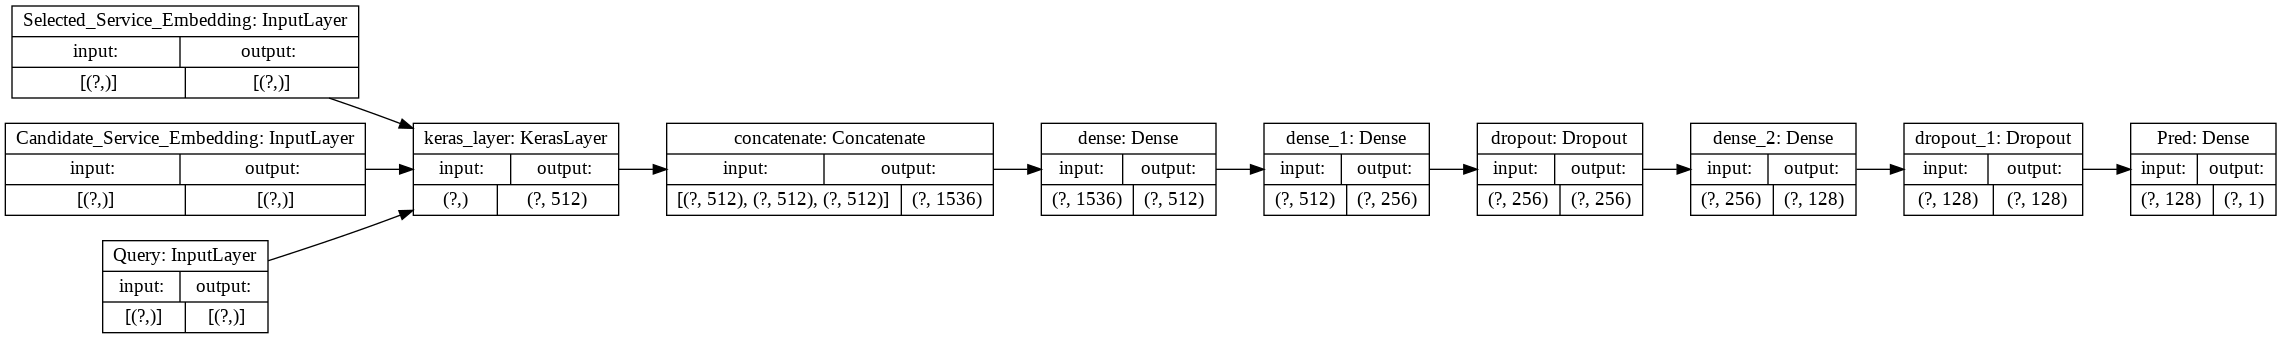

In [0]:
tf.keras.utils.plot_model(deep_model, os.path.join(PREFIX, 'figures', 'deep_keras_model.png'), show_shapes=True, rankdir='LR')

In [0]:
# with strategy.scope():
# deep_model.compile(optimizer='Adagrad', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Recall', 'Precision'])

train_dict = {}
for col in DEEP_COLUMNS:
    train_dict[col] = X_tr[col].values
val_dict = {}
for col in DEEP_COLUMNS:
    val_dict[col] = X_vl[col].values
train_ds = deep_input_fn(X_tr, y_train)

model_hist = deep_model.fit(train_ds, epochs=TRAIN_EPOCHS, verbose=10, validation_data=(list(val_dict.values()), y_val))

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15


In [0]:
feed_dict = {}
for col in DEEP_COLUMNS:
    feed_dict[col] = X_te[col].values
# feed_dict.update({'Pred': y_train})
deep_model.evaluate(x=list(feed_dict.values()), y=y_test, batch_size=BATCH_SIZE, verbose=1)

In [0]:
!pip install plot-keras-history

In [0]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

# plot keras history metrics 
plot_history(model_hist.history)
plt.show()
plot_history(model_hist.history, path=os.path.join(PREFIX, 'figures', "deep_only_metrics.png"))
plt.close()

# follow for full model report
# https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search
# https://www.machinecurve.com/index.php/2019/10/08/how-to-visualize-the-training-process-in-keras/

In [0]:
MODEL_TYP = 'deep-USE'
MODEL_DIR = os.path.join(PREFIX, 'models', 'wide_and_deep_{}'.format(MODEL), MODEL_TYP)
model_fpath = os.path.join(MODEL_DIR, '{}-model.h5'.format(MODEL_TYP))
deep_model.save(model_fpath)

In [0]:
wide_deep = tf.estimator.DNNLinearCombinedClassifier(
    model_dir=None, linear_feature_columns=wide_columns, linear_optimizer='Ftrl',
    dnn_feature_columns=deep_columns, dnn_optimizer='Adagrad', dnn_hidden_units=[256,128,64],
    dnn_activation_fn=tf.nn.relu, dnn_dropout=0.3, n_classes=2, weight_column=None,
    label_vocabulary=None, config=None, warm_start_from=None,
    batch_norm=True,linear_sparse_combiner='sum')

In [0]:
eval_hist = Out[27]
print(eval_hist)

In [0]:
%load_ext tensorboard
%tensorboard --logdir "$MODEL_DIR/" #--debugger_port 6969 

In [0]:
train_spec = tf.estimator.TrainSpec(input_fn=lambda: input_fn(X_tr, y_train))
eval_spec = tf.estimator.EvalSpec(input_fn=lambda: input_fn(X_te, y_test), name='wide-deep-care-net_batch-size_{}'.format(BATCH_SIZE),
                                  start_delay_secs=2, throttle_secs=10)
evals, exports = tf.estimator.train_and_evaluate(model_estimator, train_spec, eval_spec)

In [0]:
qq    train_spec = tf.estimator.TrainSpec(input_fn=lambda: input_fn(X_tr, y_train))
eval_spec = tf.estimator.EvalSpec(input_fn=lambda: input_fn(X_te, y_test), name='wide-deep-care-net_batch-size_{}'.format(BATCH_SIZE),
                                  start_delay_secs=2, throttle_secs=10)
evals, exports = tf.estimator.train_and_evaluate(wide_deep, train_spec, eval_spec)

In [0]:
X_tr['Selected_Service_Embedding'].values

In [0]:
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# train_ds = input_fn(X_tr, y_train)
# test_ds = input_fn(X_te, y_test, shuffle=False)
num_5k_steps = math.ceil(len(X_te) / 5000) 
train_steps = math.ceil(len(X_tr) / num_5k_steps)

accs, precs, recs, f1s = [],[],[],[]
for i in range(num_5k_steps):
    print('='*20, "Train/Eval round {}/{}".format(i,num_5k_steps), '='*20)
    eval_er.train(input_fn=lambda: input_fn(X_tr, y_train), steps=train_steps)

    start_idx = i * train_steps
    end_idx = start_idx + train_steps
    print("Using train samples {} to {}".format(start_idx,end_idx))
    X_metr = None
    preds = None
    y_metr = None
    if end_idx <= len(X_train):
        X_metr = pd.DataFrame(X_train).iloc[start_idx:end_idx]
        print("Using subset of train data with size {}".format(len(X_metr)))
        X_metr.columns = CSV_COLUMNS
        y_metr = y_train[start_idx:end_idx]
        preds = eval_er.predict(input_fn=lambda: input_fn(X_metr, y_metr))
    else:
        X_metr = pd.DataFrame(X_train).iloc[start_idx::]
        X_metr.columns = CSV_COLUMNS
        y_metr = y_train[start_idx::]
        preds = eval_er.predict(input_fn=lambda: input_fn(X_metr, y_metr))
    yhat = []
    for i in range(train_steps):
        pred = next(preds)
        print(pred.keys())
        yhat.append(pred['Pred'])
    print("Going through {} predictions for training subset".format(len(yhat)))
    yhat_classes = list(map(lambda x: np.round(x),yhat))
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_metr, yhat_classes)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_metr, yhat_classes)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_metr, yhat_classes)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_metr, yhat_classes)
    print('F1 score: %f' % f1)
    accs.append(accuracy)
    precs.append(precision)
    recs.append(recall)
    f1s.append(f1)

    eval_er.evaluate(input_fn=lambda: input_fn(X_te, y_test, shuffle=False), steps=5000, name='5kEvals')

In [0]:
    cfname = os.path.join(MODEL_DIR, 'label_metadata.tsv')
with open(fname, 'w') as f:
    f.write("Index\tLabel\tRecommended\n")
    sids = list(tagged_embeds.keys())
    for idx in range(len(sids)):
        typ = None
        if sids[idx] in hin_nodes:
            name = hin_nodes[sids[idx]]['name']
            typ = 'Service'
        else:
            name = sids[idx]
            typ = 'Query'
        # sel_name = serv_nodes[sel_idx]['name']
        # cand_idx = str(int(X_t['Candidate_Service_Embedding'].values[idx]))
        # try:
            # cand_name = serv_nodes[cand_idx]['name']
        # except:
            # continue
        # name = "{}-{}".format(sel_name, cand_name)
        f.write("{}\t{}\t{}\n".format(idx, name, typ))

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

preds = eval_er.predict(lambda: input_fn(X_t, y_test,shuffle=False))
# yhat = np.array([tf.argmax(pred['Pred'],1) for pred in preds])[:,0]
yhat = []
for pred in preds:
    yhat.append(pred['Pred'])
yhat_classes = list(map(lambda x: np.round(x),yhat))


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)


In [0]:
import datetime
X_t = pd.DataFrame(X_test)
X_t.columns = CSV_COLUMNS
# X_t.columns = DEEP_COLUMNS
# X_t.columns = WIDE_COLUMNS #+ ['Selected_Service_ID']


preds = eval_er.evaluate(lambda: input_fn(X_t, y_test,shuffle=False), name='evalShuffled')
# preds = eval_er.predict(lambda: input_fn(X_t, y_test,shuffle=False))
# print(next(preds))

In [0]:
    !rm -rf MODEL_DIR

In [0]:
print("Loading model as keras model from {}".format(export_path))
export_path = os.path.join('/tmp/census_model', "1585107419")
keras_model = tf.keras.models.load_model(export_path, compile=False)

In [0]:
print(keras_model.asset_paths)

In [0]:
keras_model.tensorflow_version
tf.keras.utils.plot_model(keras_model, 'census_test_model.png', show_shapes=False, rankdir='LR')

In [0]:
!ls "$export_path/../"

In [0]:
# FLAGS, unparsed = parser.parse_known_args()
# tf.app.run(argv=[sys.argv[0]] + unparsed)

# if not tf.compat.v1.gfile.Exists(FLAGS.data_dir):
#     tf.compat.v1.gfile.MkDir(FLAGS.data_dir)

# data_df = pd.DataFrame()
# data_df, labels = load_df(DATA_DIR)


In [0]:
# dataset = complete_dataset(data_df)
# TEST_PCT = 0.3
# test_size = int(TEST_PCT * len(dataset))
# train_size = int(len(dataset) - test_size)

# test_data = dataset.take(test_size)
# train_data = dataset.skip(test_size)

In [0]:
# def build_estimator(model_dir, model_type):
#   """Build an estimator appropriate for the given model type."""
#   wide_columns, deep_columns = build_model_columns()
#   hidden_units = [100, 75, 50, 25]

#   # Create a tf.estimator.RunConfig to ensure the model is run on GPU
#   run_config = tf.estimator.RunConfig().replace(
#       session_config=tf.compat.v1.ConfigProto(device_count={'GPU': 1}))

#   if LEARN_TYPE == 'wide':
#     return tf.estimator.LinearClassifier(
#         model_dir=model_dir,
#         feature_columns=wide_columns,
#         config=run_config)
#   elif LEARN_TYPE == 'deep':
#     return tf.estimator.DNNClassifier(
#         model_dir=model_dir,
#         feature_columns=deep_columns,
#         hidden_units=hidden_units,
#         config=run_config)
#   else:
#     return tf.estimator.DNNLinearCombinedClassifier(
#         model_dir=model_dir,
#         linear_feature_columns=wide_columns,
#         dnn_feature_columns=deep_columns,
#         dnn_hidden_units=hidden_units,
#         config=run_config)

In [0]:
def input_fn(data_files, num_epochs, shuffle, batch_size):
#     """Generate an input function for the Estimator."""
#     # assert tf.compat.v1.gfile.Exists(data_file), (
#     #     '%s not found. Please make sure you have either run data_download.py or '
#     #     'set both arguments --train_data and --test_data.' % data_file)

#     def parse_dataset_lines(value):
#         # print('Parsing dataset...')
#         columns = tf.io.decode_csv(value, record_defaults=CSV_COLUMN_DEFAULTS, select_cols=[0,1,2,3,4,6,7])
#         print(columns)
#         print()
#         # refactor our data. TODO change this directly when creating dataset
#         lbl = columns.pop(-1)
#         labels = {'Label': tf.py_function(func=preproc_lbl,
#                                                 inp=[lbl],
#                                                 Tout=tf.int32)}
#         # labels = lbl
#         CSV_COLUMNS[-1] = 'Selected_Service_ID'
#         columns = columns + [columns[3]]
#         print("Pass1")
#         features = dict(zip(CSV_COLUMNS, columns))
#         features.pop(CSV_COLUMNS[5])
#         features[CSV_COLUMNS[-1]] = columns[3]
#         print("Pass2")
#         for i in (3,4):
#             feat = features[CSV_COLUMNS[i]]
#             features[CSV_COLUMNS[i]] = tf.py_function(func=preproc_serv,
#                                                       inp=[feat],
#                                                       Tout=(tf.float32))
#         features[CSV_COLUMNS[5]] = tf.py_function(func=preproc_query,
#                                                       inp=[feat],
#                                                       Tout=(tf.float32))
#         print(features)
#         # features[CSV_COLUMNS[5]] = tf.py_function(func=preproc_rec,
#                                                             #  inp=[features[CSV_COLUMNS[5]]],
#         print("Pass3")                                        #  Tout=(tf.int32))
#         return features, labels
        
#     # Extract lines from input files using the Dataset API.
#     # data_files = tf.io.matching_files(tf.convert_to_tensor(data_files))
    
#     dfs = tf.data.Dataset.from_tensor_slices(data_files)
#     # dataset = tf.data.TextLineDataset(data_files)
#     dataset = tf.data.TextLineDataset(data_files)
#     print(dataset)
#     if shuffle:
#         dataset = dataset.shuffle(buffer_size=TRAIN_SIZE)
#     dataset = dataset.map(parse_dataset_lines, num_parallel_calls=multiprocessing.cpu_count())
#     print("Pass4")
#     # dataset = dataset.map(fn, num_parallel_calls=multiprocessing.cpu_count())
#     # dataset = dataset.map(parse_dataset, num_parallel_calls=multiprocessing.cpu_count())

#     # We call repeat after shuffling, rather than before, to prevent separate
#     # epochs from blending together.
#     print(dataset)
#     dataset = dataset.repeat(TRAIN_EPOCHS)
#     dataset = dataset.batch(batch_size)
#     dataset = dataset.prefetch(buffer_size=BATCH_SIZE)
#     print("Pass5")
#     return dataset

In [0]:
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

# # Clean up the model directory if present
# shutil.rmtree(MODEL_DIR, ignore_errors=True)
# model = build_estimator(MODEL_DIR, LEARN_TYPE)

In [0]:

# for n in range(TRAIN_EPOCHS // EPOCHS_PER_EVAL):
#     model.train(input_fn=lambda: input_fn(
#         data_files=train_files,
#         num_epochs=EPOCHS_PER_EVAL,
#         shuffle=True,
#         batch_size=BATCH_SIZE))

#     results = model.evaluate(input_fn=lambda: input_fn(
#         data_files=test_files,
#         num_epochs=1,
#         shuffle=False,
#         batch_size=BATCH_SIZE))

#     # Display evaluation metrics
#     print('Results at epoch', (n + 1) * EPOCHS_PER_EVAL)
#     print('-' * 60)

#     for key in sorted(results):
#         print('%s: %s' % (key, results[key]))